## Question 5

### Importing relevant libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
import xlsxwriter
import xlrd
from openpyxl.chart import Reference, LineChart, ScatterChart, Series
from openpyxl.drawing.image import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from datetime import timedelta, date
import datetime as datetime
from dateparser import parse
from dateutil.relativedelta import relativedelta

# To enable offline mode
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.express as px
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

pd.options.display.precision=4
plt.style.use('seaborn-ticks')

C:\Users\MANAS\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\MANAS\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\MANAS\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


C:\Users\MANAS\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning:

Module "zipline.assets" not found; multipliers will not be applied to position notionals.



### Strategy

In [2]:
def compute_daily_returns(data):
    data['cc_returns']=data['close']/data['close'].shift(1)
    return data

In [3]:
def compute_indicators(df, fast, slow):

    df['avg_hlc'] = (df['close']+df['high']+df['low'])/3
    df['mafast'] = df['avg_hlc'].rolling(window=fast).mean()
    df['maslow'] = df['avg_hlc'].rolling(window=slow).mean()
    
    return df

In [4]:
def backtest_strategy(df, lev, cap):
    
    df['signal'] = np.where((df['mafast']>df['maslow']), 1, np.where((df['mafast']<df['maslow']),-1,0))
    df['signalshift'] = df['signal'].shift(1)
    df = df.dropna()
    df['signalshift'] = df['signalshift'].astype(int)
    df['original_signal'] = np.where((df['signal'] != df['signalshift']), df['signal'], 0)

    df['position'] = df['signal'].replace(to_replace=0, method='ffill')
    
    df['buy_price'] = np.where(df['original_signal'] == 1, df['close'], 0)
    df['buy_position'] = df['buy_price'].replace(to_replace=0, method='ffill')

    df['sell_price'] = np.where(df['original_signal'] == -1, df['close'], 0)
    df['sell_position'] = df['sell_price'].replace(to_replace=0, method='ffill')

    df['Qty'] = np.where(df['original_signal'] != 0, (cap*lev/df['close']), 0)
    
    df['Pnl'] = 0
    for i in range(1,df.shape[0]):
        if df.signalshift.iloc[i]!=df.signal.iloc[i]:
            if (df.signalshift.iloc[i] > 0) and (df.signal.iloc[i] < 0):
                df['Pnl'].iloc[i] = (df.sell_position.iloc[i]/df.buy_position.iloc[i])-1
            elif (df.signalshift.iloc[i] < 0) and (df.signal.iloc[i] > 0):
                df['Pnl'].iloc[i] = (df.buy_position.iloc[i]/df.sell_position.iloc[i])-1 
            else:
                df['Pnl'].iloc[i] = 0
        else:
            df['Pnl'].iloc[i] = 0
   
    return df

In [5]:
def show_backtesting_results(df, cap):
    print(f'Buy and hold returns:',(np.round(df['cc_returns'].cumprod().iloc[-1], 2)-1)*100)
    print(f'Strategy returns:',((np.round(df['Pnl'].cumsum().iloc[-1], 2))*100))
    df['date'] = df.index
    df['cumm_Pnl'] = df['Pnl'].cumsum()
    df['cc_returns'] = df['cc_returns'].cumprod()-1
    df['Portfolio'] = cap + df['cumm_Pnl']*cap
    df['W/L'] = np.where((df['Pnl']>0), 1, np.where((df['Pnl']<0),-1,0))
    
    df['PV'] = 0
    for i in range(1, df.shape[0]):
        df['PV'].iloc[i] = df['Portfolio'].iloc[0:i].max()
    df['PV'] = df['PV'].replace(to_replace=0, method='ffill')
    df['ROllingDD'] = df['PV'] - df['Portfolio']
    df['ROllingDD_per'] = ((df['PV']/df['Portfolio'])-1)*100
    df['PnL(Money)'] = df.Pnl*data.Qty
    df[['cc_returns', 'cumm_Pnl','position']].iplot(secondary_y='position')
    df[['mafast', 'maslow','original_signal']].iplot(secondary_y='original_signal')
    df[['Portfolio']].iplot()
    fig = px.scatter(df[['Pnl','date']], x="date", y="Pnl", color='Pnl')
    fig.show()
    

In [6]:
temp = pd.read_csv("nifty50.csv")

In [7]:
temp

datetime      open      high       low     close  volume
0     2020-07-01 09:15:00  10323.80  10355.70  10299.80  10328.55       0
1     2020-07-01 09:45:00  10328.40  10363.15  10328.40  10350.45       0
2     2020-07-01 10:15:00  10350.35  10350.35  10324.70  10331.20       0
3     2020-07-01 10:45:00  10330.35  10350.50  10318.55  10336.60       0
4     2020-07-01 11:15:00  10336.95  10371.85  10329.80  10362.35       0
...                   ...       ...       ...       ...       ...     ...
6647  2022-07-20 13:15:00  16530.65  16567.00  16522.05  16555.95       0
6648  2022-07-20 13:45:00  16555.90  16565.00  16536.45  16547.05       0
6649  2022-07-20 14:15:00  16547.45  16547.80  16516.50  16519.75       0
6650  2022-07-20 14:45:00  16520.50  16542.40  16515.55  16516.20       0
6651  2022-07-20 15:15:00  16515.80  16521.90  16491.15  16495.80       0

[6652 rows x 6 columns]

### Arguments/Output

Buy and hold returns: 56.00000000000001
Strategy returns: 44.0


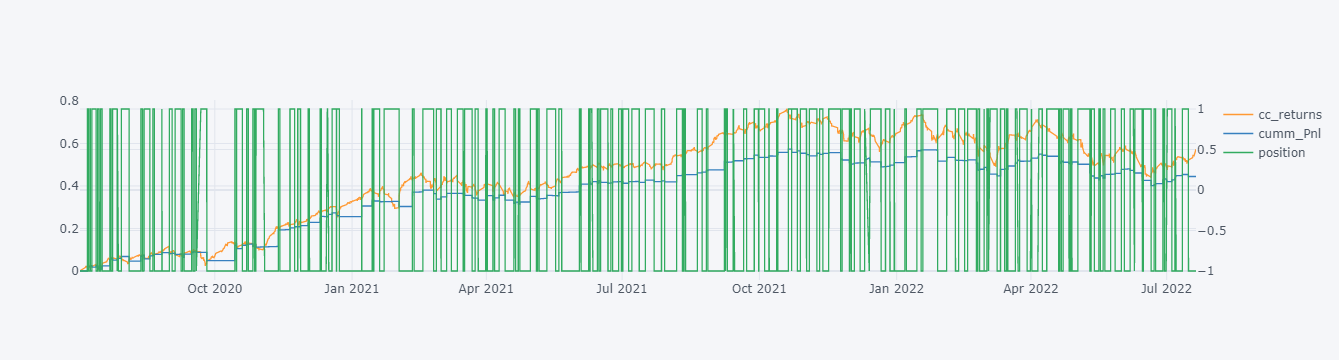

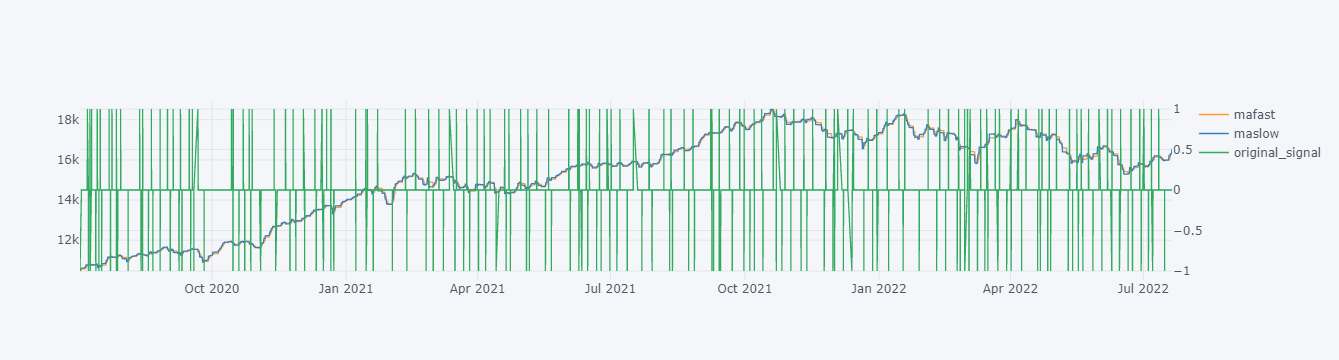

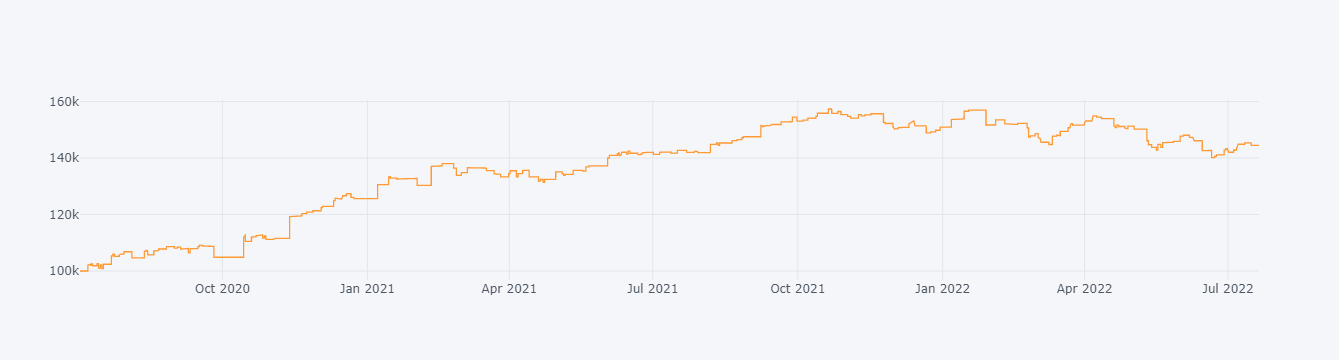

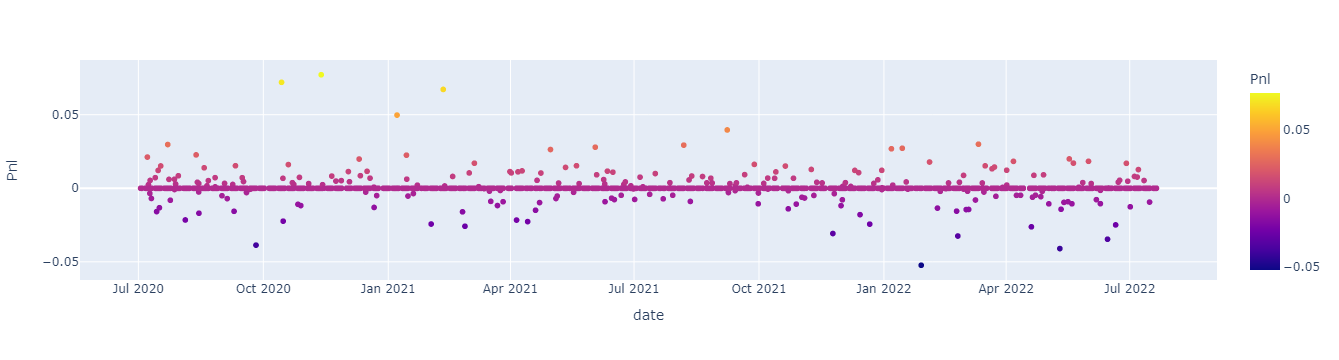

In [8]:
cap = 100000
df = temp.copy()
df.set_index('datetime', inplace = True)
data = compute_daily_returns(df)
data = compute_indicators(df, 26, 12)
data = backtest_strategy(data, 1, cap)
show_backtesting_results(data, cap)

In [9]:
data.head(50)

open      high       low     close  volume  \
datetime                                                              
2020-07-02 15:15:00  10546.55  10564.95  10539.60  10563.60       0   
2020-07-03 09:15:00  10614.95  10627.90  10573.45  10575.45       0   
2020-07-03 09:45:00  10574.75  10604.90  10565.70  10597.15       0   
2020-07-03 10:15:00  10597.60  10610.90  10585.40  10594.05       0   
2020-07-03 10:45:00  10594.55  10610.95  10578.45  10589.50       0   
2020-07-03 11:15:00  10588.95  10617.00  10581.70  10616.35       0   
2020-07-03 11:45:00  10615.60  10630.80  10609.10  10613.95       0   
2020-07-03 12:15:00  10614.95  10627.10  10600.10  10602.70       0   
2020-07-03 12:45:00  10601.70  10604.50  10587.70  10588.65       0   
2020-07-03 13:15:00  10587.85  10602.25  10563.05  10571.10       0   
2020-07-03 13:45:00  10571.05  10612.50  10565.30  10603.35       0   
2020-07-03 14:15:00  10602.45  10606.60  10579.90  10594.40       0   
2020-07-03 14:45:00  10594.90  10608.55  10585.45  10606.85       0   
2020-07-03 15:15:00  10606.75  10620.75  10600.45  10602.70       0   
2020-07-06 09:15:00  10723.85  10730.85  10695.95  10727.25       0   
2020-07-06 09:45:00  10726.60  10753.15  10719.40  10736.70       0   
2020-07-06 10:15:00  10736.55  10745.60  10728.50  10736.70       0   
2020-07-06 10:45:00  10736.65  10749.00  10735.00  10749.00       0   
2020-07-06 11:15:00  10748.95  10763.90  10745.40  10762.35       0   
2020-07-06 11:45:00  10762.80  10768.35  10753.05  10765.60       0   
2020-07-06 12:15:00  10765.65  10777.60  10762.30  10775.40       0   
2020-07-06 12:45:00  10775.20  10799.65  10775.20  10795.05       0   
2020-07-06 13:15:00  10794.90  10810.75  10791.40  10791.40       0   
2020-07-06 13:45:00  10792.35  10793.75  10763.35  10768.85       0   
2020-07-06 14:15:00  10769.05  10778.60  10749.70  10749.95       0   
2020-07-06 14:45:00  10750.55  10768.15  10748.55  10767.05       0   
2020-07-06 15:15:00  10766.20  10779.50  10756.55  10770.05       0   
2020-07-07 09:15:00  10802.85  10802.85  10753.80  10770.35       0   
2020-07-07 09:45:00  10770.65  10781.90  10752.90  10775.00       0   
2020-07-07 10:15:00  10774.95  10793.15  10745.30  10773.90       0   
2020-07-07 10:45:00  10774.20  10774.65  10726.20  10733.50       0   
2020-07-07 11:15:00  10733.45  10733.45  10690.10  10704.70       0   
2020-07-07 11:45:00  10704.60  10728.95  10701.35  10728.40       0   
2020-07-07 12:15:00  10728.60  10775.95  10720.05  10751.35       0   
2020-07-07 12:45:00  10750.95  10770.50  10742.25  10767.75       0   
2020-07-07 13:15:00  10766.70  10795.50  10759.70  10773.15       0   
2020-07-07 13:45:00  10773.00  10773.40  10741.55  10769.40       0   
2020-07-07 14:15:00  10769.40  10788.40  10765.60  10777.75       0   
2020-07-07 14:45:00  10777.60  10813.35  10770.60  10796.90       0   
2020-07-07 15:15:00  10797.30  10806.30  10780.70  10787.50       0   
2020-07-08 09:15:00  10818.65  10847.70  10798.35  10821.30       0   
2020-07-08 09:45:00  10820.30  10830.70  10785.10  10788.10       0   
2020-07-08 10:15:00  10788.40  10817.90  10785.00  10813.90       0   
2020-07-08 10:45:00  10813.80  10815.00  10786.90  10795.25       0   
2020-07-08 11:15:00  10795.30  10814.70  10773.05  10776.25       0   
2020-07-08 11:45:00  10775.45  10792.60  10767.70  10791.20       0   
2020-07-08 12:15:00  10791.70  10810.45  10779.45  10809.40       0   
2020-07-08 12:45:00  10810.00  10818.90  10796.35  10807.90       0   
2020-07-08 13:15:00  10807.90  10826.55  10789.05  10821.30       0   
2020-07-08 13:45:00  10822.30  10833.50  10805.65  10823.35       0   

                     cc_returns     avg_hlc      mafast      maslow  signal  \
datetime                                                                      
2020-07-02 15:15:00      0.0017  10556.0500  10466.2449  10548.4694      -1   
2020-07-03 09:15:00      0.0028  10592.2667  10476.4083  10553.5278      -1   
2020-07-03 09:45

### Saving bactesting results in .xlsx file

In [10]:
wb = Workbook()
ws = wb.active
ws.title = 'chart'
for r in dataframe_to_rows(data[['Pnl','cumm_Pnl','W/L','ROllingDD','ROllingDD_per','Portfolio','date']], index=True, header=True):
    ws.append(r)
values = Reference(ws, min_col= 7, min_row=2, max_col = 7, max_row = 488)
x_values = Reference(ws, range_string="chart!A2:A488")

In [11]:
chart = LineChart()
chart.add_data(values, titles_from_data = True)
chart.set_categories(x_values)

chart.title = 'Equity Curve'
chart.x_axis.title = 'Date'
chart.y_axis.title = 'Portfolio'
chart.legend.position = 'b'
ws.add_chart(chart, 'J2')

In [12]:
schart = ScatterChart()
schart.title = "Scatter Plot"
schart.x_axis.title = 'Date'
schart.y_axis.title = 'Percentage'

xvalues = Reference(ws, min_col=1, min_row=2, max_row=1)
for i in range(2, 3):
    values = Reference(ws, min_col=i, min_row=2, max_row=2)
    series = Series(values, xvalues, title_from_data=True)
    schart.series.append(series)
ws.add_chart(schart, "J17")

In [13]:
metrics = { "Total_profit": np.round(data['Portfolio'].iloc[-1] - cap,2),
            "Initial_capital": np.round(cap,2),
            "ROI": np.round(data['cumm_Pnl'].iloc[-1],2),
            "hit_ratio": np.round(data['W/L'].value_counts()[1]/(data['W/L'].value_counts()[-1] + data['W/L'].value_counts()[1]),2),
            "Gross_profit": np.round(data['PnL(Money)'].loc[data['PnL(Money)']>0].sum(),2) ,
            "Gross_loss": np.round(data['PnL(Money)'].loc[data['PnL(Money)']<0].sum(),2),
            "Avg_profit": np.round(data['PnL(Money)'].loc[data['PnL(Money)']>0].mean(),2),
            "Avg_loss": np.round(data['PnL(Money)'].loc[data['PnL(Money)']<0].mean(),2),
            "Max_Profit": np.round(max(data['PnL(Money)']),2) , 
            "Max_loss": np.round(min(data['PnL(Money)']),2),
            "Max_DD(Money)": np.round(min(data['ROllingDD'].iloc[1:]),2) ,
            "MaxDD(percent)": np.round(min(data['ROllingDD_per'].iloc[1:]),2), 
            "MaxDD(initial cap)": np.round((min(data['Portfolio'].loc[data['Portfolio']>cap]/100000)-1)*100,2)
            }
metrics_df = pd.DataFrame.from_dict(metrics,orient ='index')
metrics_df

0
Total_profit         44456.91
Initial_capital     100000.00
ROI                      0.44
hit_ratio                0.58
Gross_profit            10.37
Gross_loss              -7.14
Avg_profit               0.07
Avg_loss                -0.07
Max_Profit               0.61
Max_loss                -0.35
Max_DD(Money)        -6503.85
MaxDD(percent)          -5.45
MaxDD(initial cap)       0.88

In [14]:
for r in range(metrics_df.shape[0]):
    ws.cell(row=r+32, column=10).value = metrics_df.index[r]
    ws.cell(row=r+32, column=11).value = metrics_df[0].iloc[r]
wb.save("chart_eg.xlsx")